The purpose of this notebook is to **analyze the subway stations according to their proportion of transfers in their ridership**. Data was created using the [Hourly subway ridership dataset](https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/about_data). Note: transfers are only for out-of-system transfers and multi-modal transfers (bus->subway) -- between train transfers (from within the same station complex) are not included. 

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geodatasets import get_path
path_to_file = get_path('nybb')
import matplotlib.pyplot as plt
import requests

# Analysis of Payment Methods 
Are there more metrocard payments at high transfer ratio stations?

### Geo Data

In [19]:
boros = gpd.read_file(path_to_file)
boros = boros.to_crs(epsg=4326)
boros.drop(0, inplace=True) #removing staten island
# from: https://geo.nyu.edu/catalog/nyu-2451-34758
lines_gdf = gpd.read_file("./data/nyu-2451-34758-shapefile/nyu_2451_34758.shp")
lines_gdf = lines_gdf[lines_gdf['route_id']!='SI']

## Data

### Buses

In [ ]:
## bus transfers by payment method in 2024
# bus data comes from: https://data.ny.gov/resource/kv7t-n8in.json?$query=SELECT%0A%20%20%60payment_method%60%2C%0A%20%20sum(%60ridership%60)%20AS%20%60sum_ridership%60%2C%0A%20%20sum(%60transfers%60)%20AS%20%60sum_transfers%60%0AWHERE%0A%20%20%60transit_timestamp%60%0A%20%20%20%20BETWEEN%20%222024-01-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20AND%20%222025-01-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0AGROUP%20BY%20%60payment_method%60
bus_payment_df = pd.DataFrame(columns=['Payment_method', 'Ridership', 'Transfers'], data=[['metrocard', 235840935, 36278726], ['omny', 155891507, 33486138]])
bus_payment_df['transfer_ratio'] = round(bus_payment_df['Transfers'] / bus_payment_df['Ridership'], 3)
# OMNY users are more likely to be transferring on buses versus metrocard users on buses (subways have more metrocard users transferring)
# ~19% of Bus riders arrive via a transfer versus ~4% of subway riders
bus_payment_df

,Payment_method,Ridership,Transfers,transfer_ratio
0,metrocard,235840935,36278726,0.154
1,omny,155891507,33486138,0.215


In [ ]:
# more transfers are made using metrocard in the buses
round(36278726 / (36278726 + 33486138), 3)

0.52

### Subways

In [2]:
api_endpoint_payment = 'https://data.ny.gov/resource/wujg-7c2s.json?$query=SELECT%0A%20%20date_trunc_y(%60transit_timestamp%60)%20AS%20%60by_year_transit_timestamp%60%2C%0A%20%20%60station_complex_id%60%2C%0A%20%20%60station_complex%60%2C%0A%20%20%60payment_method%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%2C%0A%20%20sum(%60transfers%60)%20AS%20%60sum_transfers%60%2C%0A%20%20sum(%60ridership%60)%20AS%20%60sum_ridership%60%0AGROUP%20BY%0A%20%20date_trunc_y(%60transit_timestamp%60)%2C%0A%20%20%60station_complex_id%60%2C%0A%20%20%60station_complex%60%2C%0A%20%20%60payment_method%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%0AHAVING%0A%20%20%60by_year_transit_timestamp%60%0A%20%20%20%20%3E%3D%20%222024-01-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp'
try: # only running if API hasn't been made yet 
    response_payment
except Exception as e:
    response_payment = requests.get(api_endpoint_payment)
    response_data_payment = response_payment.json()
# the stations are separate from complexes by default
payment_transfer_df = pd.DataFrame(response_data_payment)

In [3]:
payment_transfer_df.drop(columns='by_year_transit_timestamp', inplace=True)
payment_transfer_df = payment_transfer_df[~payment_transfer_df['station_complex_id'].str.contains("TRAM")]
#  Data type fixing 
for col in payment_transfer_df.columns:
    if col not in ['station_complex', 'payment_method']:
        payment_transfer_df[col] = payment_transfer_df[col].values.astype(dtype='float')

In [ ]:
# do more people use omny or metrocard? -- Slightly more use OMNY
# 45% of transfers are made with metrocard and 43% of all riders use metrocard
payment_method_sum_df = payment_transfer_df.groupby('payment_method').sum()
payment_method_sum_df.drop(columns=['station_complex_id', 'station_complex', 'latitude'
                                    , 'longitude'], inplace=True)
payment_method_sum_df = payment_method_sum_df.T
payment_method_sum_df['metrocard_to_omny_ridership_ratio'] = payment_method_sum_df['metrocard'] /\
                                            (payment_method_sum_df['metrocard'] + payment_method_sum_df['omny'])
payment_method_sum_df

payment_method,metrocard,omny,metrocard_to_omny_ridership_ratio
sum_transfers,21793337.0,26704320.0,0.449369
sum_ridership,517534000.0,690617414.0,0.428368


In [5]:
# 4.2% of all metrocard users are transferring and 3.9% of all omny users are transferring
payment_method_sum_df.T['sum_transfers'] / payment_method_sum_df.T['sum_ridership']

payment_method
metrocard                            0.042110
omny                                 0.038667
metrocard_to_omny_ridership_ratio    1.049024
dtype: float64

In [ ]:
# merging into complexes 
stops_w_coords_payment = payment_transfer_df.groupby('station_complex_id')[['latitude', 'longitude']].mean().reset_index()
for row in range(len(payment_transfer_df)):
    for complex_row in range(len(stops_w_coords_payment)):
        if payment_transfer_df.loc[row, 'station_complex_id'] == stops_w_coords_payment.loc[complex_row, 'station_complex_id']:
            payment_transfer_df.loc[row, 'latitude'] = stops_w_coords_payment.loc[complex_row, 'latitude']
            payment_transfer_df.loc[row, 'longitude'] = stops_w_coords_payment.loc[complex_row, 'longitude']
complex_df_payment = payment_transfer_df.groupby(['station_complex', 'payment_method'])[['sum_ridership', 'sum_transfers']].sum().reset_index()
# shows ratio transfers + payment method to all users
complex_df_payment['transfer_ratio_by_payment'] = round(complex_df_payment['sum_transfers'] 
                                                        / complex_df_payment['sum_ridership'], 3)

In [ ]:
complex_df_payment_raw_transfers = complex_df_payment.pivot(index='payment_method', columns='station_complex'
                                                            , values='sum_transfers').T.reset_index()
complex_df_payment_raw_transfers['transfer_payment_type_diff'] = complex_df_payment_raw_transfers['metrocard'] \
                                                         - complex_df_payment_raw_transfers['omny']
# direct comparison of payment method by payment method
complex_df_payment_raw_transfers['transfer_ratio_metrocard'] = round(complex_df_payment_raw_transfers['metrocard'] / \
                                    (complex_df_payment_raw_transfers['metrocard'] + complex_df_payment_raw_transfers['omny']), 3)

In [44]:
complex_df_payment_raw_transfers

payment_method,station_complex,metrocard,omny,transfer_payment_type_diff,transfer_ratio_metrocard
0,1 Av (L),47877.0,93035.0,-45158.0,0.340
1,103 St (1),6882.0,13901.0,-7019.0,0.331
2,103 St (6),7707.0,10548.0,-2841.0,0.422
3,"103 St (C,B)",1514.0,4134.0,-2620.0,0.268
4,103 St-Corona Plaza (7),115027.0,177649.0,-62622.0,0.393
...,...,...,...,...,...
421,"Woodhaven Blvd (J,Z)",22847.0,25594.0,-2747.0,0.472
422,"Woodhaven Blvd (M,R)",273295.0,357233.0,-83938.0,0.433
423,Woodlawn (4),275074.0,64052.0,211022.0,0.811
424,York St (F),7757.0,22003.0,-14246.0,0.261


In [35]:
## a third of stations have more metrocard transfers than omny transfers
# complex_df_payment_raw_transfers[complex_df_payment_raw_transfers['transfer_type_diff'] > 0].count()

In [ ]:
complex_df_payment_raw_transfers.sort_values(by='transfer_ratio_metrocard').tail(10)

payment_method,station_complex,metrocard,omny,transfer_payment_type_diff,transfer_ratio_metrocard
259,Far Rockaway-Mott Av (A),58322.0,21901.0,36421.0,0.727
5,104 St (A),3204.0,1190.0,2014.0,0.729
177,Baychester Av (5),7986.0,2815.0,5171.0,0.739
254,Eastchester-Dyre Av (5),59096.0,20423.0,38673.0,0.743
346,"Nereid Av (2,5)",43635.0,14597.0,29038.0,0.749
354,"Norwood Av (J,Z)",2013.0,601.0,1412.0,0.770
405,Van Cortlandt Park-242 St (1),218964.0,54066.0,164898.0,0.802
423,Woodlawn (4),275074.0,64052.0,211022.0,0.811
91,"36 St (M,R)",6705.0,1239.0,5466.0,0.844
413,Wakefield-241 St (2),35338.0,762.0,34576.0,0.979


In [45]:
payment_ratio_df = complex_df_payment.pivot(index='station_complex', columns='payment_method'
                         , values='transfer_ratio_by_payment').reset_index()
payment_ratio_df['payment_ratio_diff'] = payment_ratio_df['metrocard'] - payment_ratio_df['omny']
# most stations have transfers via metrocard
# sns.boxplot(payment_ratio_df, y='payment_ratio_diff')
payment_ratio_df['high_diff'] = [True if abs(x) > 0.03 else False 
                                 for x in payment_ratio_df['payment_ratio_diff']]

In [91]:
complex_df_payment_gdf_pre = pd.merge(left=complex_df_payment_raw_transfers, right=payment_transfer_df, on='station_complex')
complex_df_payment_gdf_pre.drop(columns=['sum_transfers', 'sum_ridership', 'payment_method']
                           , inplace=True)
complex_df_payment_gdf_pre.drop_duplicates(inplace=True)
complex_df_payment_gdf = gpd.GeoDataFrame(complex_df_payment_gdf_pre, 
                                geometry=gpd.points_from_xy(complex_df_payment_gdf_pre.longitude, 
                                                            complex_df_payment_gdf_pre.latitude))
complex_df_payment_gdf_sorted = complex_df_payment_gdf.sort_values(by='transfer_ratio_metrocard')
# payment_ratio_gdf_sorted = payment_ratio_gdf[payment_ratio_gdf['high_diff']==True].sort_values(by='payment_ratio_diff')

In [97]:
# non terminal stations are more omny focused (people find using omny easier for transfers)
# terminal stations are metrocard focused (necessary for Bee-Line transfers)
# complex_df_payment_gdf_sorted['transfer_ratio_metrocard'].mean()
complex_df_payment_gdf_sorted

,station_complex,metrocard,omny,transfer_payment_type_diff,transfer_ratio_metrocard,station_complex_id,latitude,longitude,geometry
890,Spring St (6),1245.0,6278.0,-5033.0,0.165,409.0,40.722300,-73.997140,POINT (-73.99714 40.7223)
466,"Canal St (A,C,E)",1450.0,7346.0,-5896.0,0.165,169.0,40.720825,-74.005226,POINT (-74.00523 40.72082)
174,"28 St (R,W)",1585.0,7369.0,-5784.0,0.177,13.0,40.745495,-73.988690,POINT (-73.98869 40.7455)
892,"Spring St (C,E)",1055.0,4297.0,-3242.0,0.197,168.0,40.726227,-74.003740,POINT (-74.00374 40.72623)
464,Canal St (1),266.0,1071.0,-805.0,0.199,325.0,40.722855,-74.006280,POINT (-74.00628 40.72286)
...,...,...,...,...,...,...,...,...,...
816,"Norwood Av (J,Z)",2013.0,601.0,1412.0,0.770,88.0,40.681410,-73.880035,POINT (-73.88004 40.68141)
930,Van Cortlandt Park-242 St (1),218964.0,54066.0,164898.0,0.802,293.0,40.889248,-73.898580,POINT (-73.89858 40.88925)
966,Woodlawn (4),275074.0,64052.0,211022.0,0.811,378.0,40.886036,-73.878750,POINT (-73.87875 40.88604)
202,"36 St (M,R)",6705.0,1239.0,5466.0,0.844,272.0,40.752040,-73.928780,POINT (-73.92878 40.75204)


## Map 

<Axes: >

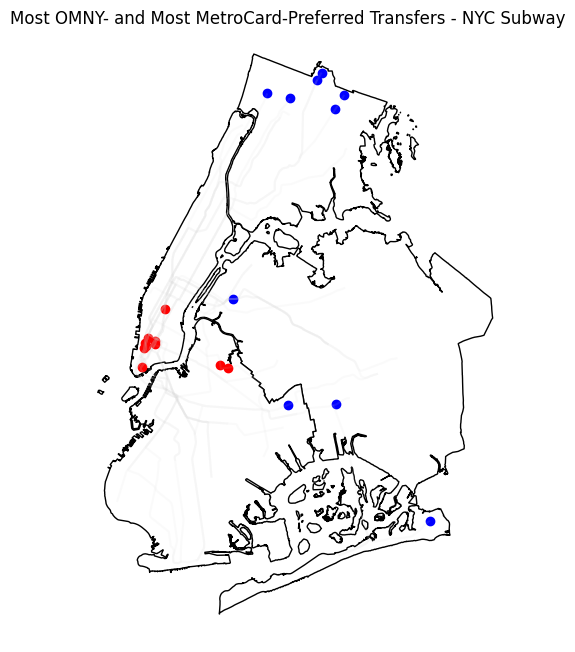

In [ ]:
# show the stations' payment method of choice for transfers 
## use diverging continuous scales to do so
fig, ax = plt.subplots(figsize=(6,8))
boros.plot(ax=ax, color="white", edgecolor="black")
plt.axis('off')
plt.suptitle('Most OMNY- and Most MetroCard-Preferred Transfers - NYC Subway',
             fontdict={'fontsize': '20','fontweight' : '3'}, y=0.9)
complex_df_payment_gdf_sorted[-10:].plot(color='Blue', ax=ax)
complex_df_payment_gdf_sorted[:10].plot(color='Red',ax=ax)
lines_gdf.plot(ax=ax, color='lightgray', alpha=0.1)
# plt.savefig("./saved_data/station_transfer_ratios_by_payment", dpi=50, bbox_inches='tight')